In [0]:
import pandas as pd

def get_df(filename, index_col=0):
    df = pd.read_csv(filename, index_col=0)
    return df

df1 = get_df('bitfinex_eth_btc_300.csv')
df2 = get_df('coinbase_pro_eth_btc_300.csv')

In [0]:
# Function to convert 5 minute data to 1 hour candles.

def change_ohlcv_time(df, period):
    """ Changes the time period on cryptocurrency ohlcv data.
        Period is a string denoted by 'time_in_minutesT'(ex: '1T', '5T', '60T')."""

    df['closing_time'] = pd.to_datetime(df['closing_time'], unit='s')

    # Set date as the index.
    df = df.set_index(['closing_time'])

    # Aggregation function
    ohlc_dict = {                                                                                                             
    'open':'first',                                                                                                    
    'high':'max',                                                                                                       
    'low':'min',                                                                                                        
    'close': 'last',                                                                                                    
    'base_volume': 'sum'
    }

    # Apply resampling.
    df = df.resample(period, how=ohlc_dict, closed='left', label='left')

    df = df.reset_index()
    
    return df

In [0]:
# Function to fill in missing values.

def fill_nan(df):
  
    '''Iterates through a dataframe and fills NaNs with appropriate open, high, low, close values.'''

    # Forward fill close column.
    df['close'] = df['close'].ffill()

    # Backward fill the open, high, low rows with the close value.
    df = df.bfill(axis=1)

    return df

In [4]:
df1 = change_ohlcv_time(df1, '60T')
df2 = change_ohlcv_time(df2, '60T')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [0]:
df1 = fill_nan(df1)
df2 = fill_nan(df2)

In [0]:
# df1 = df1.reset_index(drop=True)
# df2 = df2.reset_index(drop=True)

In [6]:
pip install ta

In [0]:
from ta import add_all_ta_features

def engineer_features(df):
    df = add_all_ta_features(df, 'open', 'high', 'low', 'close',
                             'base_volume', fillna=True)
    df = df.drop(columns=['open', 'high', 'low', 'momentum_kama',
                          'momentum_stoch', 'others_cr', 'others_dlr',
                          'trend_ema_fast', 'trend_ema_slow', 
                          'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_kst',
                          'trend_macd', 'trend_visual_ichimoku_a',
                          'trend_visual_ichimoku_b', 'volatility_bbh',
                          'volatility_bbl', 'volatility_bbm',
                          'volatility_dch', 'volatility_dcl',
                          'volatility_kcc', 'volatility_kch',
                          'volatility_kcl'])
    df['time_since_last'] = df['closing_time'].diff(-1)
    df['close_shifted'] = df['close'].shift(-1)
    return df


In [0]:
def df_to_float(df):

  df['open'] = df['open'].astype(float)
  df['close'] = df['close'].astype(float)
  df['high'] = df['high'].astype(float)
  df['low'] = df['low'].astype(float)
  df['base_volume'] = df['base_volume'].astype(float)

  return df

In [0]:
df1 = df_to_float(df1)
df2 = df_to_float(df2)

In [10]:
df1 = engineer_features(df1)
df2 = engineer_features(df2)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


In [0]:
def get_higher_closing_price(df, exchange_1, exchange_2):
    if (df['close_' + exchange_1] - df['close_shifted_' + exchange_2]) > 0:
        return exchange_1
    elif (df['close_' + exchange_1] - df['close_shifted_' + exchange_2]) < 0:
        return exchange_2
    else:
        return 'equivalent'

def get_pct_higher(df, exchange_1, exchange_2):
    if df['higher_closing_price'] == exchange_1:
        return ((df['close_shifted_' + exchange_1] / df['close_' + exchange_2])-1)*100
    elif df['higher_closing_price'] == exchange_2:
        return ((df['close_shifted_' + exchange_2] / df['close_' + exchange_1])-1)*100
    else:
        return 0
    
def get_target(df, exchange_1, exchange_2):
    if df['pct_higher'] < 0.000001:
        return 'no_arbitrage'
    elif df['higher_closing_price'] == exchange_1:
        return 'arbitrage_' + exchange_2 + '_to_' + exchange_1
    elif df['higher_closing_price'] == exchange_2:
        return 'arbitrage_' + exchange_1 + '_to_' + exchange_2
        
def merge_dfs(df1, df2, exchange_1, exchange_2):
    df = pd.merge(df1, df2, on='closing_time',
                  suffixes=('_' + exchange_1, '_' + exchange_2))
    df['higher_closing_price'] = df.apply(get_higher_closing_price,
                                          exchange_1=exchange_1,
                                          exchange_2=exchange_2, axis=1)
    df['pct_higher'] = df.apply(get_pct_higher, exchange_1=exchange_1,
                                exchange_2=exchange_2, axis=1)
    df['target'] = df.apply(get_target, exchange_1=exchange_1,
                            exchange_2=exchange_2, axis=1)
    df = df.drop(columns=['higher_closing_price', 'pct_higher'])
    # df['target'] = df['target'].shift(-1)
    # df = df[0:-1]
    return df

df = merge_dfs(df1, df2, 'bitfinex', 'coinbase_pro')

In [27]:
df[['closing_time', 'close_coinbase_pro', 'close_bitfinex', 'close_shifted_coinbase_pro', 'close_shifted_bitfinex', 'target']]

,closing_time,close_coinbase_pro,close_bitfinex,close_shifted_coinbase_pro,close_shifted_bitfinex,target
0,2016-05-18 00:00:00,0.02710,0.027550,0.03300,0.027800,arbitrage_bitfinex_to_coinbase_pro
1,2016-05-18 01:00:00,0.03300,0.027800,0.02750,0.028000,no_arbitrage
2,2016-05-18 02:00:00,0.02750,0.028000,0.02750,0.028030,arbitrage_coinbase_pro_to_bitfinex
3,2016-05-18 03:00:00,0.02750,0.028030,0.02750,0.028413,arbitrage_coinbase_pro_to_bitfinex
4,2016-05-18 04:00:00,0.02750,0.028413,0.02850,0.028137,arbitrage_bitfinex_to_coinbase_pro
...,...,...,...,...,...,...
29539,2019-09-30 19:00:00,0.02147,0.021483,0.02144,0.021453,no_arbitrage
29540,2019-09-30 20:00:00,0.02144,0.021453,0.02148,0.021471,arbitrage_bitfinex_to_coinbase_pro
29541,2019-09-30 21:00:00,0.02148,0.021471,0.02155,0.021546,arbitrage_bitfinex_to_coinbase_pro
29542,2019-09-30 22:00:00,0.02155,0.021546,0.02170,0.021677,arbitrage_bitfinex_to_coinbase_pro


In [0]:
df = df[0:-1]

In [20]:
start_of_oct_2018 = '2018-10-01 01:00:00' #1538352000
start_of_jan_2019 = '2019-01-01 01:00:00' #1546300800

target = ['target']

train = df[df['closing_time'] < start_of_oct_2018]
test = df[df['closing_time'] > start_of_jan_2019]

X_train = train.drop(columns=target).reset_index(drop=True)
y_train = train[target].reset_index(drop=True)

X_test = test.drop(columns=target).reset_index(drop=True)
y_test = test[target].reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20785, 87), (20785, 1), (6550, 87), (6550, 1))

In [0]:
X_train = X_train.drop(columns=['closing_time', 'time_since_last_bitfinex', 'time_since_last_coinbase_pro'])
X_test = X_test.drop(columns=['closing_time', 'time_since_last_bitfinex', 'time_since_last_coinbase_pro'])

In [22]:
#XGBClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_accuracy = accuracy_score(y_train, pred_train)
test_accuracy = accuracy_score(y_test, pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.5910031272552322
Test Accuracy: 0.48732824427480914


In [24]:
# Logistic Regession

from sklearn.linear_model import LogisticRegression


model_logistic = LogisticRegression(solver='lbfgs', multi_class='auto',
                           max_iter=10000)

model_logistic.fit(X_train, y_train)


pred_train = model_logistic.predict(X_train)
pred_test = model_logistic.predict(X_test)

train_accuracy = accuracy_score(y_train, pred_train)
test_accuracy = accuracy_score(y_test, pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.5299975944190523
Test Accuracy: 0.4772519083969466


In [26]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=50, n_estimators=100, n_jobs=-1)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_accuracy = accuracy_score(y_train, pred_train)
test_accuracy = accuracy_score(y_test, pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Train Accuracy: 1.0
Test Accuracy: 0.47908396946564885


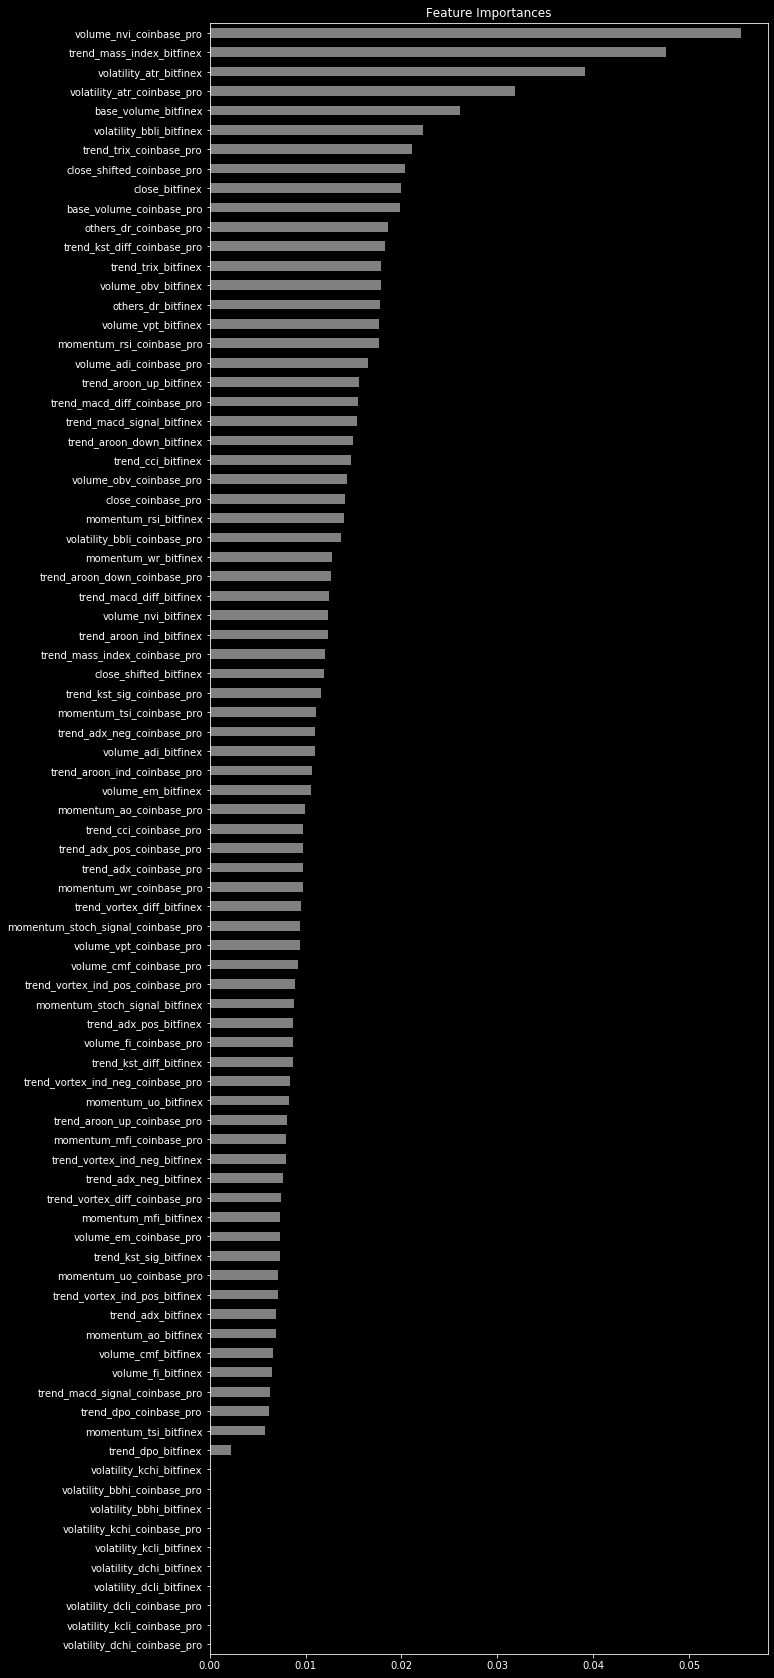

In [17]:
import matplotlib.pyplot as plt

coefficients = pd.Series(
    model.feature_importances_, X_train.columns)
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,30))
plt.title('Feature Importances')
coefficients.sort_values().plot.barh(color='grey');
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

labels = unique_labels(y_test)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}'  for label in labels]

pd.DataFrame(confusion_matrix(y_test, pred_test),
             columns=columns, index=index)

,Predicted arbitrage_bitfinex_to_coinbase_pro,Predicted arbitrage_coinbase_pro_to_bitfinex,Predicted no_arbitrage
Actual arbitrage_bitfinex_to_coinbase_pro,13,0,1549
Actual arbitrage_coinbase_pro_to_bitfinex,0,0,51
Actual no_arbitrage,6,0,4932


In [19]:
labels = unique_labels(y_train)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}'  for label in labels]

pd.DataFrame(confusion_matrix(y_train, pred_train),
             columns=columns, index=index)

,Predicted arbitrage_bitfinex_to_coinbase_pro,Predicted arbitrage_coinbase_pro_to_bitfinex,Predicted no_arbitrage
Actual arbitrage_bitfinex_to_coinbase_pro,2270,1,5692
Actual arbitrage_coinbase_pro_to_bitfinex,54,33,401
Actual no_arbitrage,904,1,11429


In [0]:
import pickle

pickle.dump(model, open("bitfinex_coinbase_pro_eth_btc_300.pickle", "wb"))

Train Accuracy: 0.6606687515034881
Test Accuracy: 0.7548465883071287


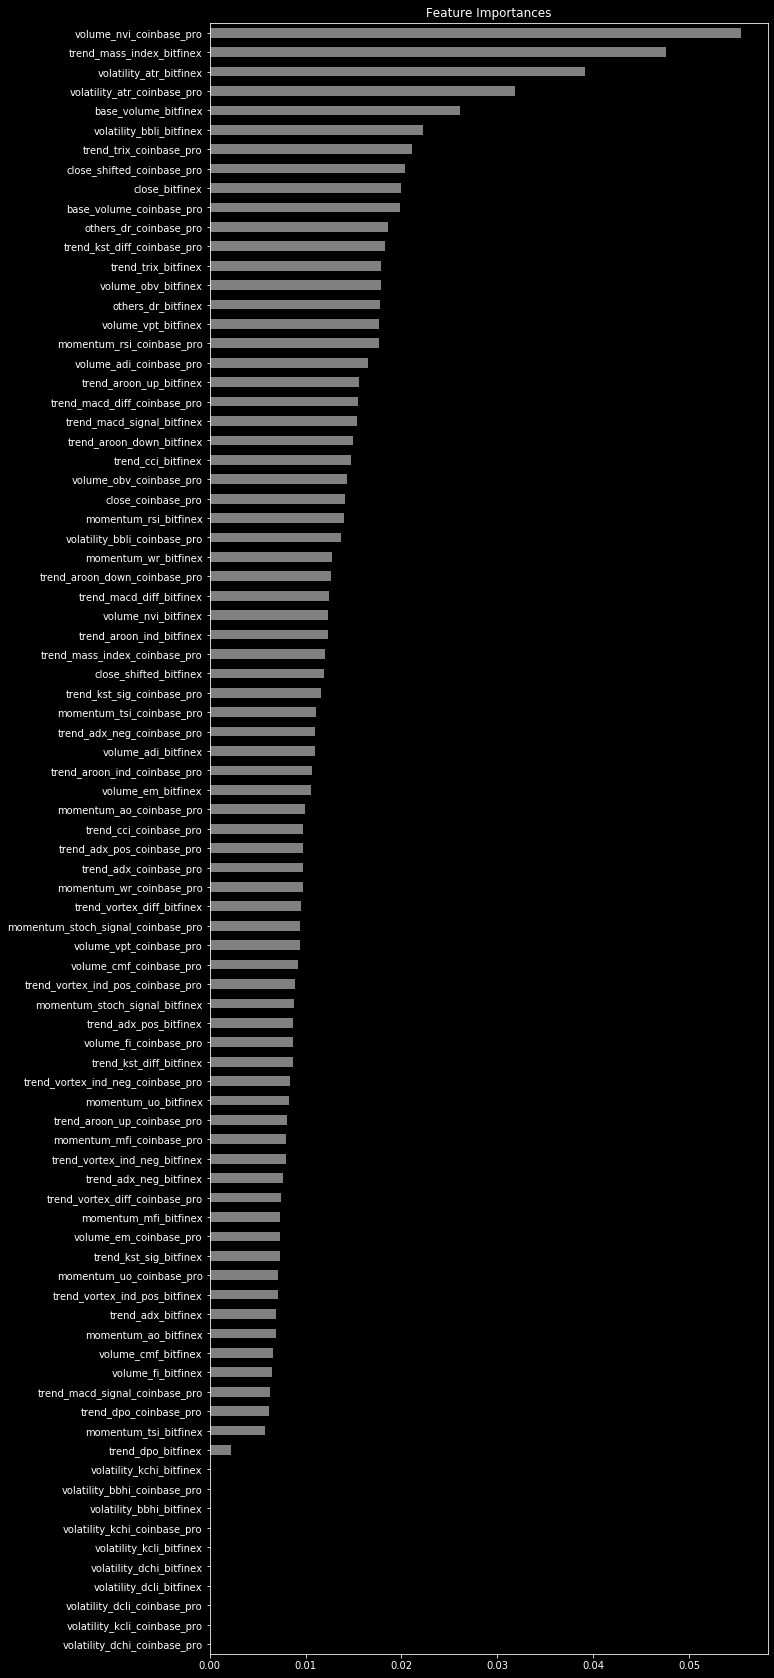

In [21]:
loaded_model = pickle.load(open("bitfinex_coinbase_pro_eth_btc_300.pickle", "rb"))

pred_train = loaded_model.predict(X_train)
pred_test = loaded_model.predict(X_test)

train_accuracy = accuracy_score(y_train, pred_train)
test_accuracy = accuracy_score(y_test, pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

coefficients = pd.Series(
    loaded_model.feature_importances_, X_train.columns)
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,30))
plt.title('Feature Importances')
coefficients.sort_values().plot.barh(color='grey');
plt.show()

In [22]:
pred_test

array(['no_arbitrage', 'no_arbitrage', 'no_arbitrage', ...,
       'no_arbitrage', 'no_arbitrage', 'no_arbitrage'], dtype=object)

In [0]:
df_pred = X_test

In [0]:
df_pred['pred_test'] = pred_test

In [25]:
df_pred

,close_bitfinex,base_volume_bitfinex,volume_adi_bitfinex,volume_obv_bitfinex,volume_cmf_bitfinex,volume_fi_bitfinex,volume_em_bitfinex,volume_vpt_bitfinex,volume_nvi_bitfinex,volatility_atr_bitfinex,volatility_bbhi_bitfinex,volatility_bbli_bitfinex,volatility_kchi_bitfinex,volatility_kcli_bitfinex,volatility_dchi_bitfinex,volatility_dcli_bitfinex,trend_macd_signal_bitfinex,trend_macd_diff_bitfinex,trend_adx_bitfinex,trend_adx_pos_bitfinex,trend_adx_neg_bitfinex,trend_vortex_ind_pos_bitfinex,trend_vortex_ind_neg_bitfinex,trend_vortex_diff_bitfinex,trend_trix_bitfinex,trend_mass_index_bitfinex,trend_cci_bitfinex,trend_dpo_bitfinex,trend_kst_sig_bitfinex,trend_kst_diff_bitfinex,trend_aroon_up_bitfinex,trend_aroon_down_bitfinex,trend_aroon_ind_bitfinex,momentum_rsi_bitfinex,momentum_mfi_bitfinex,momentum_tsi_bitfinex,momentum_uo_bitfinex,momentum_stoch_signal_bitfinex,momentum_wr_bitfinex,momentum_ao_bitfinex,...,volume_obv_coinbase_pro,volume_cmf_coinbase_pro,volume_fi_coinbase_pro,volume_em_coinbase_pro,volume_vpt_coinbase_pro,volume_nvi_coinbase_pro,volatility_atr_coinbase_pro,volatility_bbhi_coinbase_pro,volatility_bbli_coinbase_pro,volatility_kchi_coinbase_pro,volatility_kcli_coinbase_pro,volatility_dchi_coinbase_pro,volatility_dcli_coinbase_pro,trend_macd_signal_coinbase_pro,trend_macd_diff_coinbase_pro,trend_adx_coinbase_pro,trend_adx_pos_coinbase_pro,trend_adx_neg_coinbase_pro,trend_vortex_ind_pos_coinbase_pro,trend_vortex_ind_neg_coinbase_pro,trend_vortex_diff_coinbase_pro,trend_trix_coinbase_pro,trend_mass_index_coinbase_pro,trend_cci_coinbase_pro,trend_dpo_coinbase_pro,trend_kst_sig_coinbase_pro,trend_kst_diff_coinbase_pro,trend_aroon_up_coinbase_pro,trend_aroon_down_coinbase_pro,trend_aroon_ind_coinbase_pro,momentum_rsi_coinbase_pro,momentum_mfi_coinbase_pro,momentum_tsi_coinbase_pro,momentum_uo_coinbase_pro,momentum_stoch_signal_coinbase_pro,momentum_wr_coinbase_pro,momentum_ao_coinbase_pro,others_dr_coinbase_pro,close_shifted_coinbase_pro,pred_test
0,0.035357,480.264957,-440.548050,-6.310806e+05,0.051921,0.009418,-1.152845e-11,-2.778735,1525.647439,0.000246,0.0,0.0,0.0,0.0,0.0,1.0,-0.000037,-0.000059,20.640108,13.619505,28.679993,0.812937,1.167021,0.354084,-0.016537,23.501335,-118.418489,0.000295,-0.494696,-4.322496,52.0,100.0,-48.0,37.754152,28.280235,5.820551,38.805314,23.805230,-88.007214,-0.000327,...,-247462.227194,-0.092490,0.032509,-6.058242e-12,-2.751845,2163.129471,0.000238,0.0,0.0,0.0,0.0,0.0,1.0,-0.000040,-5.522656e-05,20.403217,13.340277,26.612501,0.823899,1.154088,0.330189,-0.017938,23.493984,-101.642392,0.000286,-0.919402,-4.383001,52.0,100.0,-48.0,38.710587,22.737945,6.060850,48.938536,23.000000,-87.000000,-0.000361,-0.309772,0.03551,no_arbitrage
1,0.035484,644.083538,-221.537921,-6.304365e+05,0.059593,-0.012460,-1.530571e-11,0.096128,1525.647439,0.000244,0.0,0.0,0.0,0.0,0.0,0.0,-0.000050,-0.000051,21.350323,14.264434,26.833450,0.789396,1.172312,0.382916,-0.021709,23.457256,-87.400571,0.000155,-1.418394,-5.154544,48.0,96.0,-48.0,42.553517,30.295196,5.214492,40.989826,20.739405,-76.555455,-0.000326,...,-247210.139445,-0.049651,-0.000000,-1.381656e-11,-1.225593,2169.851060,0.000234,0.0,0.0,0.0,0.0,0.0,0.0,-0.000052,-4.613241e-05,21.539603,12.606495,26.982180,0.773994,1.198142,0.424149,-0.022682,23.455511,-89.200147,0.000160,-1.863863,-5.055164,48.0,96.0,-48.0,43.049862,23.041085,5.489185,58.078274,20.333333,-76.000000,-0.000345,0.310734,0.03590,no_arbitrage
2,0.035800,2259.633801,-43.754357,-6.281768e+05,0.051679,0.788260,-8.156762e-12,22.436498,1525.647439,0.000275,0.0,0.0,0.0,0.0,0.0,0.0,-0.000056,-0.000023,20.515700,26.868259,22.132080,0.866721,1.043525,0.176805,-0.024486,23.721728,11.200984,0.000352,-2.500267,-5.002378,44.0,92.0,-48.0,52.389996,30.870793,5.200166,44.625372,30.691500,-43.362832,-0.000274,...,-244999.307315,0.001676,0.781159,-6.698076e-12,25.064499,2169.851060,0.000261,0.0,0.0,0.0,0.0,0.0,0.0,-0.000055,-1.265278e-05,20.611251,26.669106,22.471204,0.859155,1.039437,0.180282,-0.024573,23.

In [26]:
df_pred['pred_test'].value_counts()

no_arbitrage                          6532
arbitrage_bitfinex_to_coinbase_pro      19
Name: pred_test, dtype: int64

In [0]:
df_pred['binary_y_preds'] = df_pred['pred_test'].shift(1).apply(lambda x: 1 if x== 'arbitrage_bitfinex_to_coinbase_pro' else 0)

In [28]:
((df_pred['close_shifted_coinbase_pro'] / df_pred['close_bitfinex']-1)*df_pred['binary_y_preds']).sum()

0.1358380693132043